In [1]:
from multicartpole import get_urdf, ManipulatorDynamics, ManipulatorDynamicsToPolynomial, get_lqr_diagram, simulate_diagram
from pydrake.all import Variable, Linearize, LinearQuadraticRegulator, Parser, MultibodyPlant, MonomialBasis, MathematicalProgram, Variables, Solve, ToLatex

import pydrake.symbolic as sym
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

from tqdm import tqdm

In [2]:
# urdf of cartpole with 1 link
urdf = get_urdf(1)


plant = MultibodyPlant(time_step=0.0)
plant.set_name(f"plant")
Parser(plant).AddModelsFromString(urdf, "urdf")
plant.Finalize()

# LQR controller
x_equilibrium = np.zeros(4)
Q_lqr = np.diag([10, 10, 1, 1])
R_lqr = np.eye(1)

context = plant.CreateDefaultContext()
plant.SetPositionsAndVelocities(context, x_equilibrium)
plant.get_actuation_input_port().FixValue(context, [0])
linear_plant = Linearize(plant, context, plant.get_actuation_input_port().get_index(), plant.get_state_output_port().get_index())
K_lqr, S_lqr = LinearQuadraticRegulator(linear_plant.A(),linear_plant.B(),Q_lqr,R_lqr)

# Symbolic polynomial dynamics
x = Variable("x")
theta = Variable("\\theta")
q = np.array([x, theta])
sintheta = Variable("s")
costheta = Variable("c")
xdot = Variable("\\dot{x}")
thetadot = Variable("\\dot{\\theta}")
qdot = np.array([xdot, thetadot])
xdoubledot = Variable("\\ddot{x}")
thetadoubledot = Variable("\\ddot{\\theta}")
qdoubledot = np.array([xdoubledot, thetadoubledot])

symbolic_plant = plant.ToSymbolic()
symbolic_M, symbolic_C, symbolic_tauG, symbolic_B = ManipulatorDynamics(symbolic_plant, q, qdot)
polynomial_M, polynomial_C, polynomial_tauG, polynomial_B = ManipulatorDynamicsToPolynomial(symbolic_M,symbolic_C,symbolic_tauG,symbolic_B,[theta],[sintheta],[costheta])

# Polynomial force input
x_lqr = np.array([x, sintheta, xdot, thetadot])
polynomial_u = -K_lqr @ x_lqr

# Polynomial EOM constraints
polynomial_eom_constraints = polynomial_M @ qdoubledot + polynomial_C - polynomial_tauG - polynomial_B @ polynomial_u

# Polynomial circle constraint
circle_constraint = sintheta**2 + costheta**2 - 1

# Lyapunov function
x_lyapunov = np.array([x, sintheta, xdot, thetadot])
xdot_lyapunov = np.array([xdot, costheta*thetadot, xdoubledot, thetadoubledot])

alpha = 2
polynomial_V = x_lyapunov.T @ S_lqr @ x_lyapunov + alpha*(1-costheta) 
polynomial_Vdot = 2 * x_lyapunov.T @ S_lqr @ xdot_lyapunov + alpha*(sintheta*thetadot)

In [3]:
display(Markdown("$M = " + ToLatex(symbolic_M, precision=2) + "$"))
display(Markdown("$C = " + ToLatex(symbolic_C, precision=2) + "$"))
display(Markdown("$\\tau_G = " + ToLatex(symbolic_tauG, precision=2) + "$"))
display(Markdown("$B = " + ToLatex(symbolic_B, precision=2) + "$"))


display(Markdown("Polinomial EOM constraints $ = " + ToLatex(polynomial_eom_constraints, precision=2) + "$"))
display(Markdown("Circle constraint $ = " + ToLatex(circle_constraint, precision=2) + "$"))

display(Markdown("$V = " + ToLatex(polynomial_V, precision=2) + "$"))
display(Markdown("$\\dot{V} = " + ToLatex(polynomial_Vdot, precision=2) + "$"))

$M = \begin{bmatrix} 2 & -1 \cos{\theta} \\ -1 \cos{\theta} & 1 \end{bmatrix}$

$C = \begin{bmatrix} \dot{\theta}^{2} \sin{\theta} \\ 0 \end{bmatrix}$

$\tau_G = \begin{bmatrix} 0 \\ 9.81 \sin{\theta} \end{bmatrix}$

$B = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$

Polinomial EOM constraints $ = \begin{bmatrix} ( - 3.16x + 61.40s - 5.29\dot{x} + 16.17\dot{\theta} + 2\ddot{x} + s \dot{\theta}^{2} - c \ddot{\theta}) \\ ( - 9.81s + \ddot{\theta} - c \ddot{x}) \end{bmatrix}$

Circle constraint $ = (-1 + s^{2} + c^{2})$

$V = (2(1 - c) + x (16.71x - 51.13s + 13.47\dot{x} - 16.63\dot{\theta}) + s ( - 51.13x + 454.03s - 68.83\dot{x} + 130.23\dot{\theta}) + \dot{x} (13.47x - 68.83s + 17.30\dot{x} - 22.58\dot{\theta}) + \dot{\theta} ( - 16.63x + 130.23s - 22.58\dot{x} + 38.75\dot{\theta}))$

$\dot{V} = (2s \dot{\theta} + c \dot{\theta} ( - 102.27x + 908.05s - 137.67\dot{x} + 260.47\dot{\theta}) + \dot{x} (33.43x - 102.27s + 26.93\dot{x} - 33.26\dot{\theta}) + \ddot{x} (26.93x - 137.67s + 34.59\dot{x} - 45.16\dot{\theta}) + \ddot{\theta} ( - 33.26x + 260.47s - 45.16\dot{x} + 77.50\dot{\theta}))$

<h4> equality constrained formulation </h4>

In [4]:
prog = MathematicalProgram()


variables = np.array([x, sintheta, costheta, xdot, thetadot, xdoubledot, thetadoubledot])
indets = prog.NewIndeterminates(7)
subs = dict(zip(variables, indets))
        
V = polynomial_V.Substitute(subs)
Vdot = polynomial_Vdot.Substitute(subs)
eom = sym.Substitute(polynomial_eom_constraints,subs)
circle = circle_constraint.Substitute(subs)

# multipliers
l_e = np.array([prog.NewFreePolynomial(Variables(indets), 1).ToExpression() for i in range(2)])
l_c = prog.NewFreePolynomial(Variables(indets), 3).ToExpression()

l = prog.NewFreePolynomial(Variables(indets), 2).ToExpression()

rho = prog.NewContinuousVariables(1)[0]
prog.AddConstraint(rho >= 0)

symbolic_xxd = np.array([x, sintheta, costheta-1, xdot, thetadot]).T @ np.array([x, sintheta, costheta-1, xdot, thetadot])
xxd = symbolic_xxd.Substitute(subs)

sos_const = xxd * (V - rho) - l*Vdot - l_e.T@eom - l_c*circle

Q, basis_m = prog.AddSosConstraint(sos_const[0])
prog.AddLinearCost(-rho)

result = Solve(prog)

print(result.is_success())

rho_sol = result.GetSolution(rho)
print(rho_sol)

True
0.24317028829996803


<h4> Sampling algebraic variety </h4>

In [5]:
def sample_variety():
    prog = MathematicalProgram()

    alpha = np.random.randn(3)
    beta = np.random.randn(3)
    angle = np.random.uniform(-np.pi,np.pi)

    t = prog.NewContinuousVariables(1)[0]
    subs = dict(zip([x, xdot, thetadot], alpha*t+beta))
    
    sin_sample, cos_sample = np.sin(angle), np.cos(angle)
    subs_trig = dict(zip([sintheta, costheta], [sin_sample, cos_sample]))
    subs.update(subs_trig)

    this_M = sym.Evaluate(polynomial_M, subs_trig)
    this_C = sym.Substitute(polynomial_C, subs)
    this_tauG = sym.Evaluate(polynomial_tauG, subs_trig)
    this_B = sym.Evaluate(polynomial_B, subs_trig)
    this_u = sym.Substitute(polynomial_u, subs)

    this_M_inv = np.linalg.inv(this_M)

    this_qdd = this_M_inv@(this_tauG + this_B@this_u - this_C)
    subs.update(dict(zip(qdoubledot, this_qdd.flatten())))

    this_Vdot = polynomial_Vdot.Substitute(subs)
    prog.AddConstraint(this_Vdot == 0)
    result = Solve(prog)
    success = result.is_success()
    
    if success:
        t_found = result.GetSolution(t)
        this_Vdot = this_Vdot.Evaluate({t:t_found})
        
        sol_dict = dict(zip([x, xdot, thetadot], alpha*t_found+beta))
        sol_dict[theta] = angle
        sol_dict.update(subs_trig)
        sol_dict.update(dict(zip(qdoubledot, sym.Evaluate(this_qdd, {t:t_found}).flatten())))

        this_V = polynomial_V.Evaluate(sol_dict)
        if this_Vdot == 0 and this_V < 1e4:
            return sol_dict, this_V, this_Vdot
    return sample_variety()

n_samples = 100

subs_samples = [sample_variety()[0] for i in tqdm(range(n_samples))]

100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


In [6]:
prog = MathematicalProgram()

symbolic_psi = np.array([m.ToExpression().Substitute(dict(zip(indets, variables))) for m in basis_m])
# symbolic_psi = np.array([m.ToExpression() for m in MonomialBasis(variables, 2)])

rho = prog.NewContinuousVariables(1, "r")[0]
prog.AddConstraint(rho >= 0)

dim_psi = len(symbolic_psi)

P = prog.NewSymmetricContinuousVariables(dim_psi, "P")
prog.AddPositiveSemidefiniteConstraint(P)

for subs in subs_samples:
    xxd = symbolic_xxd.Evaluate(subs)
    V = polynomial_V.Evaluate(subs)
    psi = sym.Evaluate(symbolic_psi, subs)
    prog.AddConstraint((xxd * (V - rho) - psi.T@P@psi)[0,0] == 0)
    
prog.AddCost(-rho)

result = Solve(prog)

print(result.is_success())
print(result.GetSolution(rho))

True
10.244761057250235


<h4> Simulation </h4>

In [7]:
urdf = get_urdf(1)
diagram = get_lqr_diagram(urdf, 1)

x_lim = 2
n = 101

th = np.linspace(-1, 1, n)
thdot = np.linspace(-1, 1, n)

roa = -np.ones((n,n))

logger = diagram.GetSubsystemByName("logger")

for i in tqdm(range(n)):
    for j in range(n):
        try:
            x0 = np.array([0,th[i], 0, thdot[j]])
            context = simulate_diagram(diagram, x0, 5)
            log = logger.FindLog(context)

            if np.max(np.abs(log.data()[0,:])) < x_lim and np.max(np.abs(log.data()[1,:])) < np.pi/2:
                roa[n-j-1,i] = np.max(np.abs(log.data()[0,:]))
        except:
            continue

100%|██████████| 101/101 [01:00<00:00,  1.66it/s]


<h4> Sampling 1 </h4>

In [8]:
def evaluate_Vdot(subs):
    M = sym.Evaluate(polynomial_M, subs)
    C = sym.Evaluate(polynomial_C, subs)
    tauG = sym.Evaluate(polynomial_tauG, subs)
    B = sym.Evaluate(polynomial_B, subs)
    u = sym.Evaluate(polynomial_u, subs)

    M_inv = np.linalg.inv(M)

    qdd = M_inv@(tauG + B@u - C)
    subs.update(dict(zip(qdoubledot, qdd.flatten())))
    return polynomial_Vdot.Evaluate(subs)

x_lim = 2

x_max = np.array([x_lim, np.pi/2, 3, 3])
V_max = np.inf

for i in tqdm(range(500000)):
    state = (np.random.rand(4)*2-1) * x_max
    subs = {x: state[0], sintheta: np.sin(state[1]), costheta: np.cos(state[1]), theta: state[1], xdot: state[2], thetadot: state[3]}
    V = polynomial_V.Evaluate(subs)
    Vdot = evaluate_Vdot(subs)
    if Vdot > 0 and V < V_max:
        V_max = V

100%|██████████| 500000/500000 [00:50<00:00, 9981.04it/s] 


<h4> Sampling 2 </h4>

In [9]:
def sample_variety_2(): # in this we do not check for Vdot = 0 (much faster), we check later for Vdot >= 0
    prog = MathematicalProgram()

    alpha = np.random.randn(3)
    beta = np.random.randn(3)
    angle = np.random.uniform(-np.pi,np.pi)

    t = prog.NewContinuousVariables(1)[0]
    subs = dict(zip([x, xdot, thetadot], alpha*t+beta))
    
    sin_sample, cos_sample = np.sin(angle), np.cos(angle)
    subs_trig = dict(zip([sintheta, costheta], [sin_sample, cos_sample]))
    subs.update(subs_trig)

    this_M = sym.Evaluate(polynomial_M, subs_trig)
    this_C = sym.Substitute(polynomial_C, subs)
    this_tauG = sym.Evaluate(polynomial_tauG, subs_trig)
    this_B = sym.Evaluate(polynomial_B, subs_trig)
    this_u = sym.Substitute(polynomial_u, subs)

    this_M_inv = np.linalg.inv(this_M)

    this_qdd = this_M_inv@(this_tauG + this_B@this_u - this_C)
    subs.update(dict(zip(qdoubledot, this_qdd.flatten())))

    this_Vdot = polynomial_Vdot.Substitute(subs)
    prog.AddConstraint(this_Vdot == 0)
    result = Solve(prog)
    success = result.is_success()
    
    if success:
        t_found = result.GetSolution(t)
        this_Vdot = this_Vdot.Evaluate({t:t_found})
        
        sol_dict = dict(zip([x, xdot, thetadot], alpha*t_found+beta))
        sol_dict[theta] = angle
        sol_dict.update(subs_trig)
        sol_dict.update(dict(zip(qdoubledot, sym.Evaluate(this_qdd, {t:t_found}).flatten())))

        this_V = polynomial_V.Evaluate(sol_dict)
        if this_V < 1e4: # we do not check for Vdot = 0 in this line
            return sol_dict, this_V, this_Vdot
    return sample_variety()

samples = [sample_variety_2() for _ in tqdm(range(5000))]

V_max2 = np.inf
for _, V, Vdot in samples:
    if Vdot >= 0 and V < V_max2:
        V_max2 = V

100%|██████████| 5000/5000 [02:31<00:00, 32.99it/s]


In [10]:
print("V max:",V_max)
print("V max 2:",V_max2)

V max: 2.721209937944888
V max 2: 2.5998341421086977


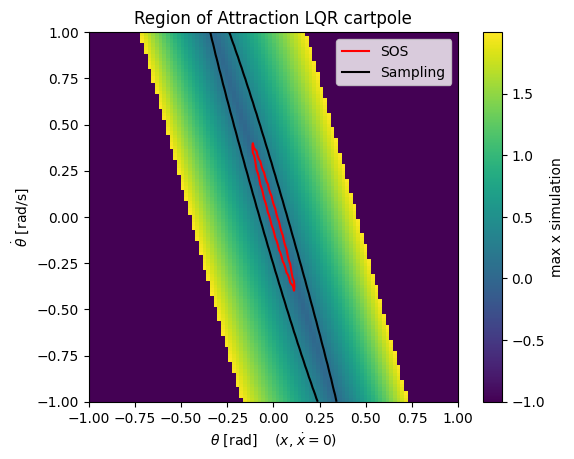

In [11]:
x1_lim = (-1, 1)
x2_lim = (-1, 1)

fig, ax = plt.subplots()
plt.title("Region of Attraction LQR cartpole")

def V(state):
    subs = {x: 0, sintheta: np.sin(state[0]), costheta: np.cos(state[0]), theta: state[0], xdot: 0, thetadot: state[1]}
    return polynomial_V.Evaluate(subs)

x1 = np.linspace(*x1_lim,100)
x2 = np.linspace(*x2_lim,100)
X1, X2 = np.meshgrid(x1, x2)

Y = np.zeros_like(X1)
for i in range(len(x1)):
    for j in range(len(x2)):
        state = np.array([X1[i, j], X2[i, j]])
        Y[i,j] = V(state)

cs = ax.contour(X1,X2,Y, levels = [rho_sol], colors='r')
cs = ax.contour(X1,X2,Y, levels = [min([V_max, V_max2])], colors='k')

ax.plot([], color='r', label = "SOS")
ax.plot([], color='k', label = "Sampling")

im = ax.imshow(roa, extent=[*x1_lim, *x2_lim])

ax.set_xlabel("$\\theta$ [rad]    ($x$, $\\dot{x} = 0$)")
ax.set_ylabel("$\\dot\\theta$ [rad/s]")

plt.colorbar(im, label = "max x simulation")

ax.legend()

plt.show()